Available label columns: ['mouse_line', 'cre_driver_1', 'cre_driver_2', 'cre_reporter', 'dissection', 'tdTomato', 'pass_qc_checks', 'broad_type', 'core_intermediate', 'primary_type', 'secondary_type', 'aibs_vignette_id']


c:\Users\ibrah\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Fixed Hyperparameters ===
Hierarchical: linkage='ward', n_clusters = #true labels
KMeans: n_clusters = #true labels, n_init=10, random_state=0
DBSCAN: eps=0.5, min_samples=5
Leiden: n_neighbors=15, resolution=1.0, random_state=0

GSE71585 - Hierarchical_ward | ARI: 0.430, Silhouette: 0.299


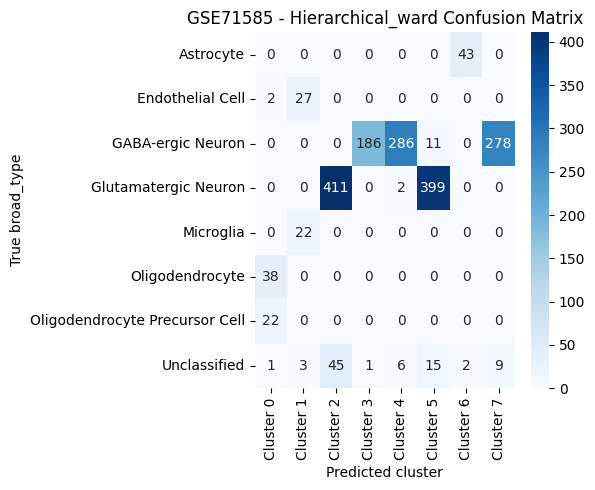

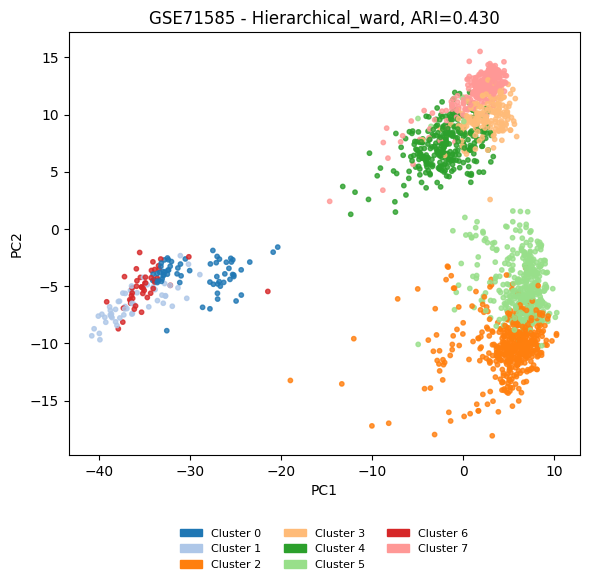

GSE71585 - Hierarchical_average | ARI: 0.228, Silhouette: 0.414


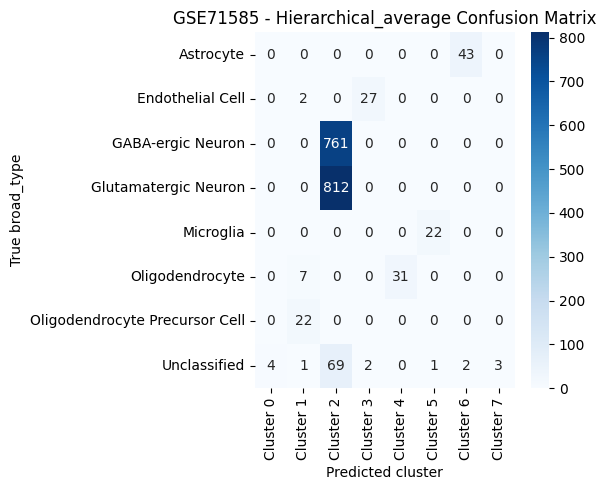

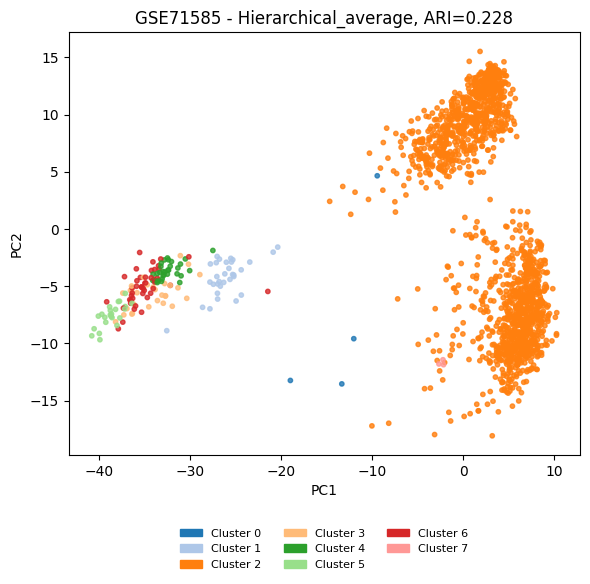

GSE71585 - KMeans_k6 | ARI: 0.522, Silhouette: 0.267


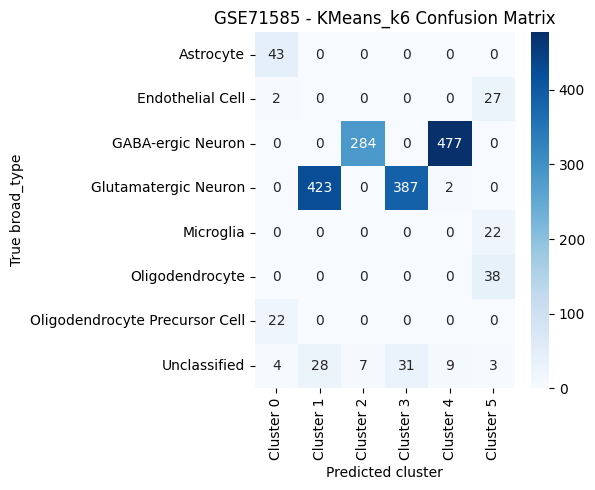

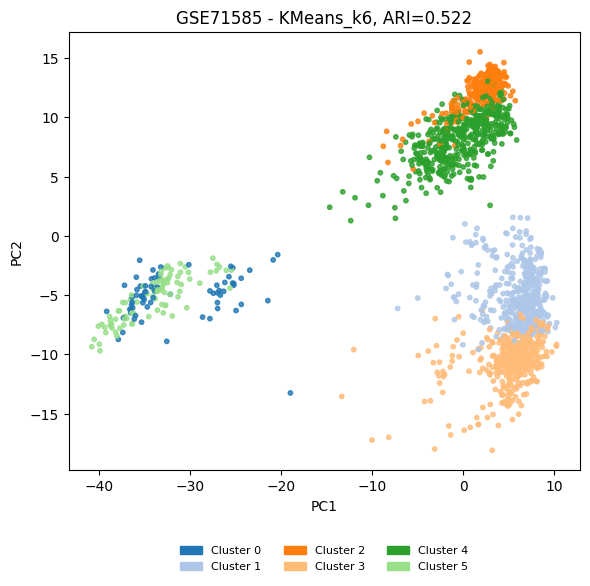

GSE71585 - KMeans_k8 | ARI: 0.439, Silhouette: 0.307


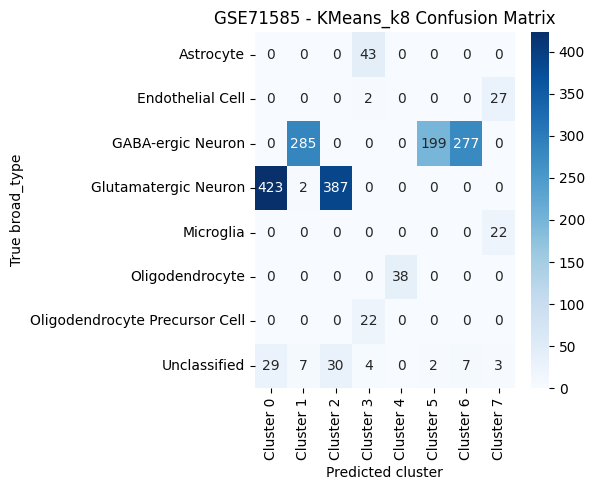

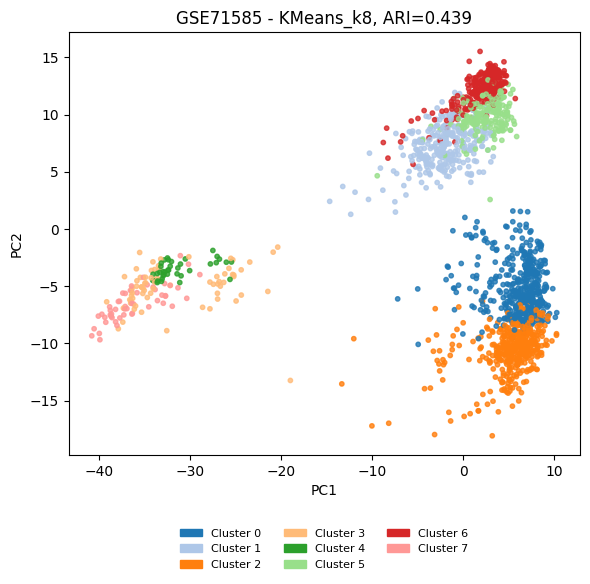

GSE71585 - KMeans_k10 | ARI: 0.380, Silhouette: 0.315


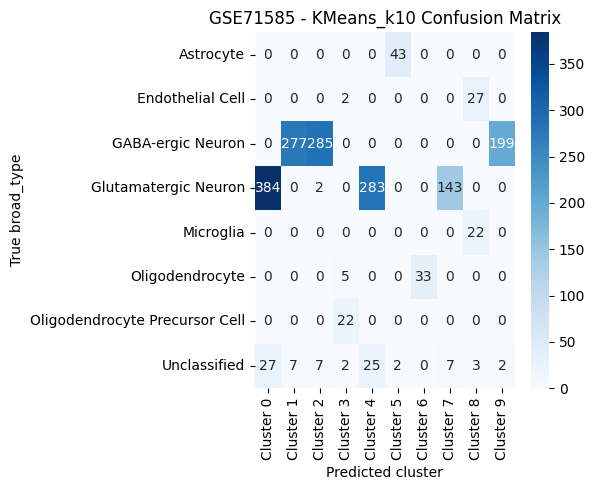

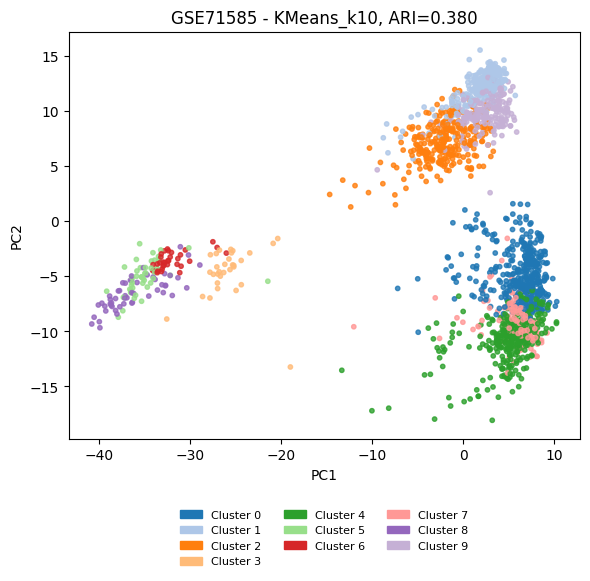

GSE71585 - DBSCAN_eps0.3 | ARI: 0.221, Silhouette: -0.000


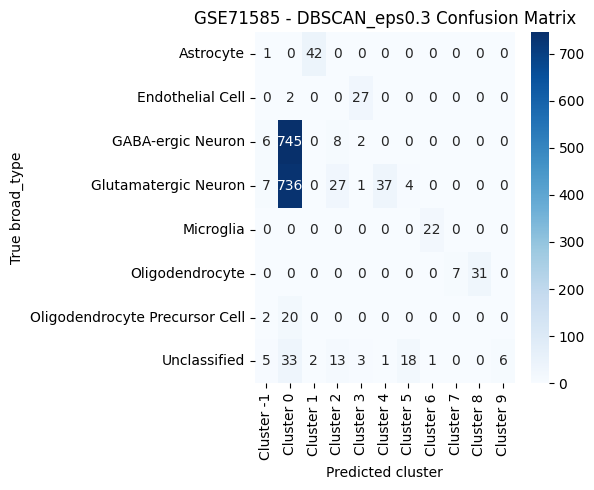

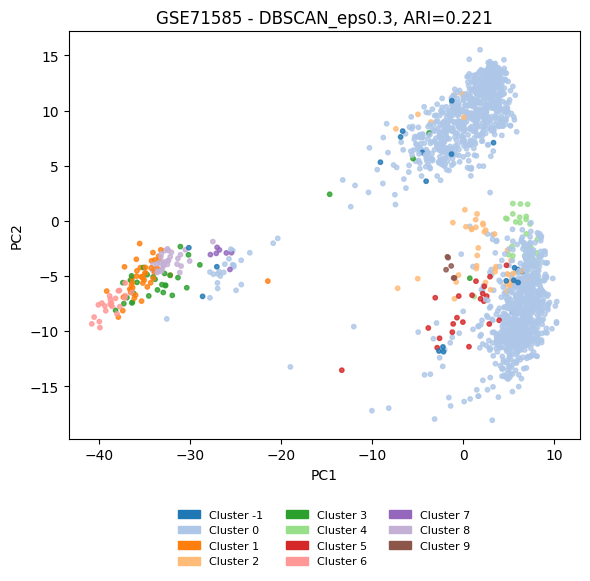

GSE71585 - DBSCAN_eps0.5 | ARI: 0.147, Silhouette: -0.062


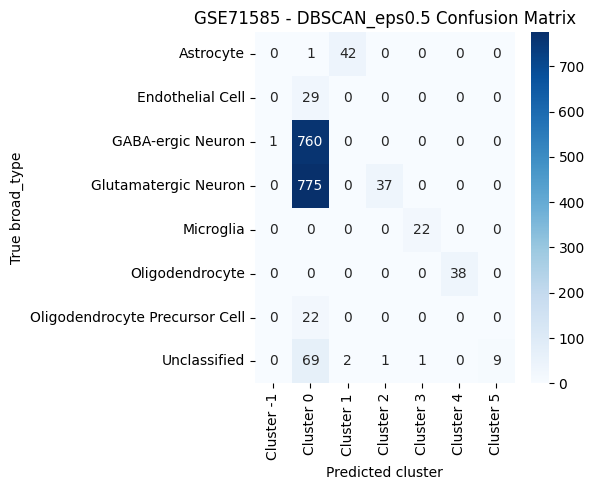

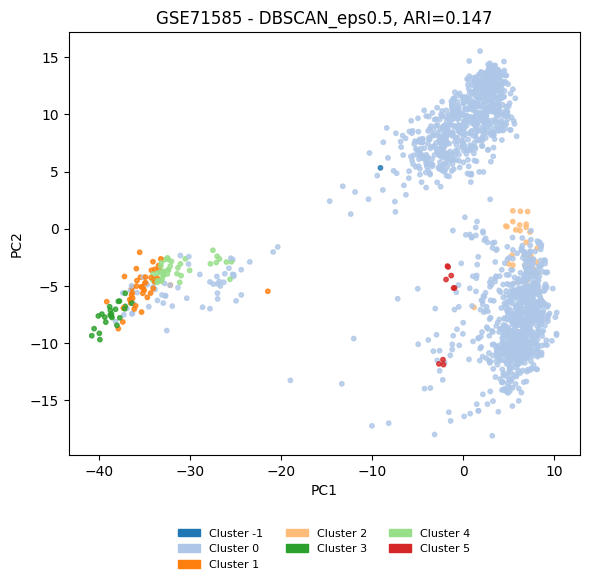

GSE71585 - DBSCAN_eps0.7 | ARI: 0.083, Silhouette: 0.478


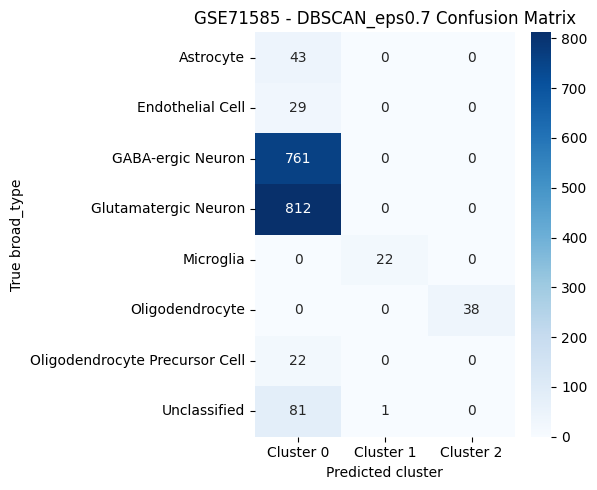

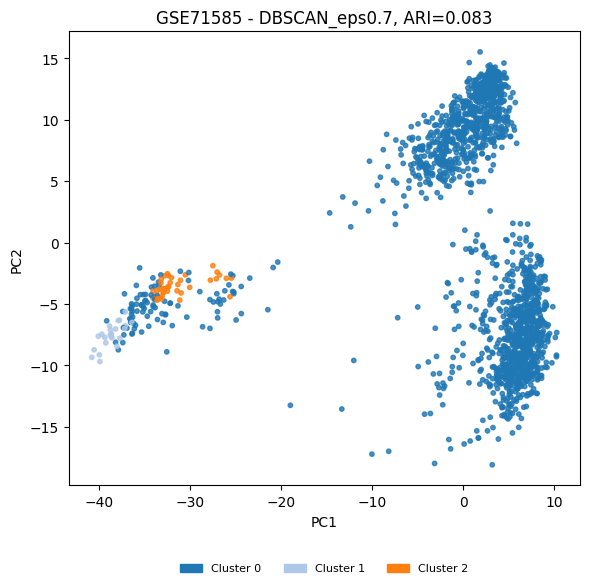

GSE71585 - Leiden_res0.5 | ARI: 0.433, Silhouette: 0.109


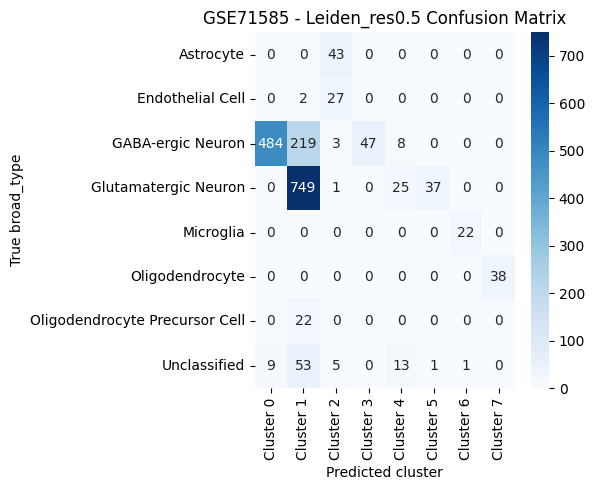

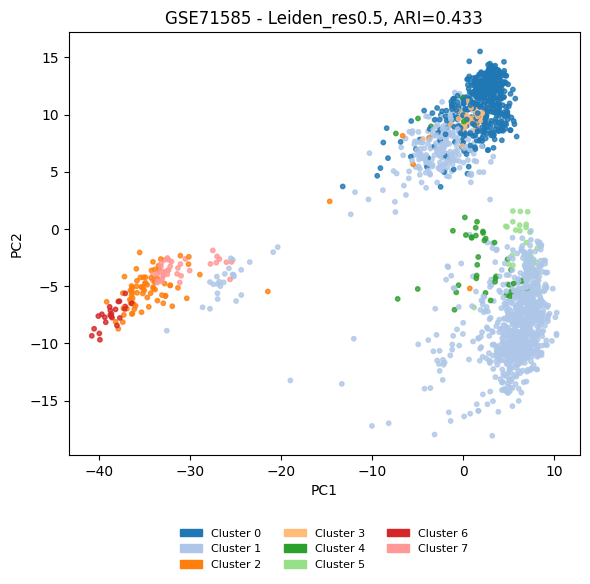

GSE71585 - Leiden_res1.0 | ARI: 0.467, Silhouette: 0.232


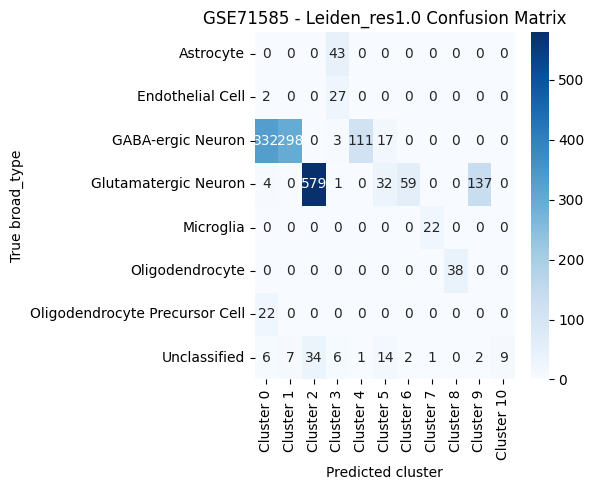

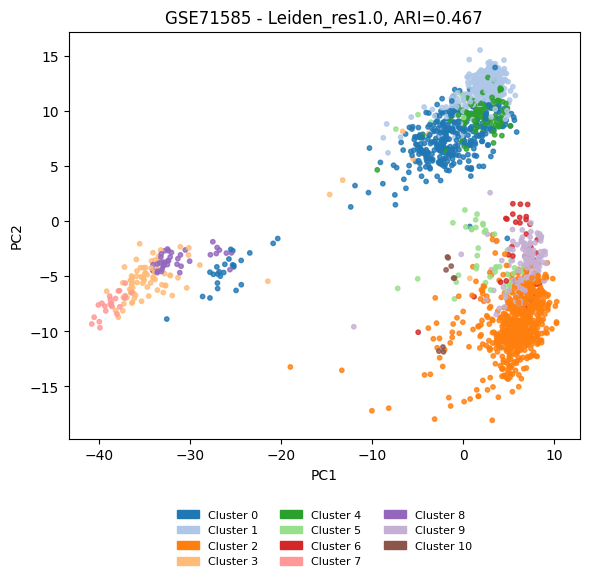

GSE71585 - Leiden_res1.5 | ARI: 0.337, Silhouette: 0.262


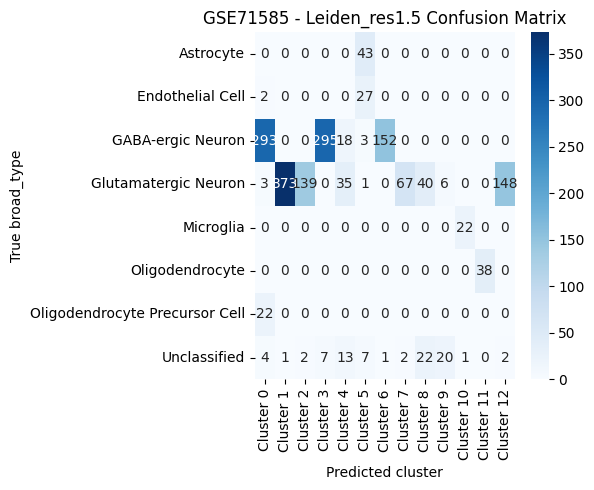

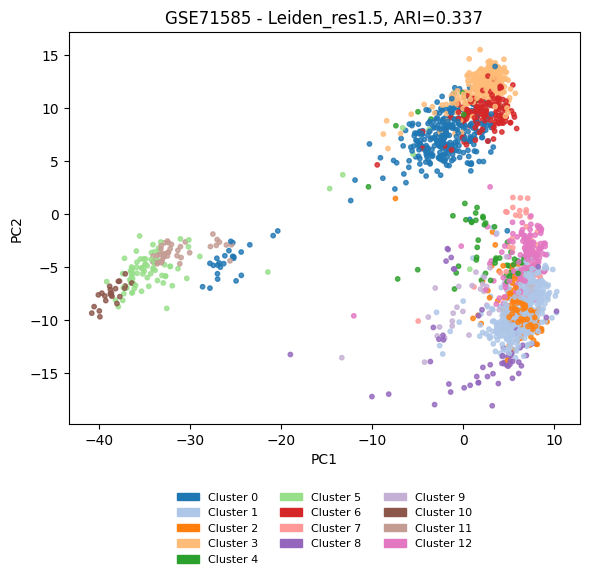


=== Summary Table ===
              Method   ARI  Silhouette  n_clusters_pred
   Hierarchical_ward 0.430       0.299                8
Hierarchical_average 0.228       0.414                8
           KMeans_k6 0.522       0.267                6
           KMeans_k8 0.439       0.307                8
          KMeans_k10 0.380       0.315               10
       DBSCAN_eps0.3 0.221      -0.000               11
       DBSCAN_eps0.5 0.147      -0.062                7
       DBSCAN_eps0.7 0.083       0.478                3
       Leiden_res0.5 0.433       0.109                8
       Leiden_res1.0 0.467       0.232               11
       Leiden_res1.5 0.337       0.262               13


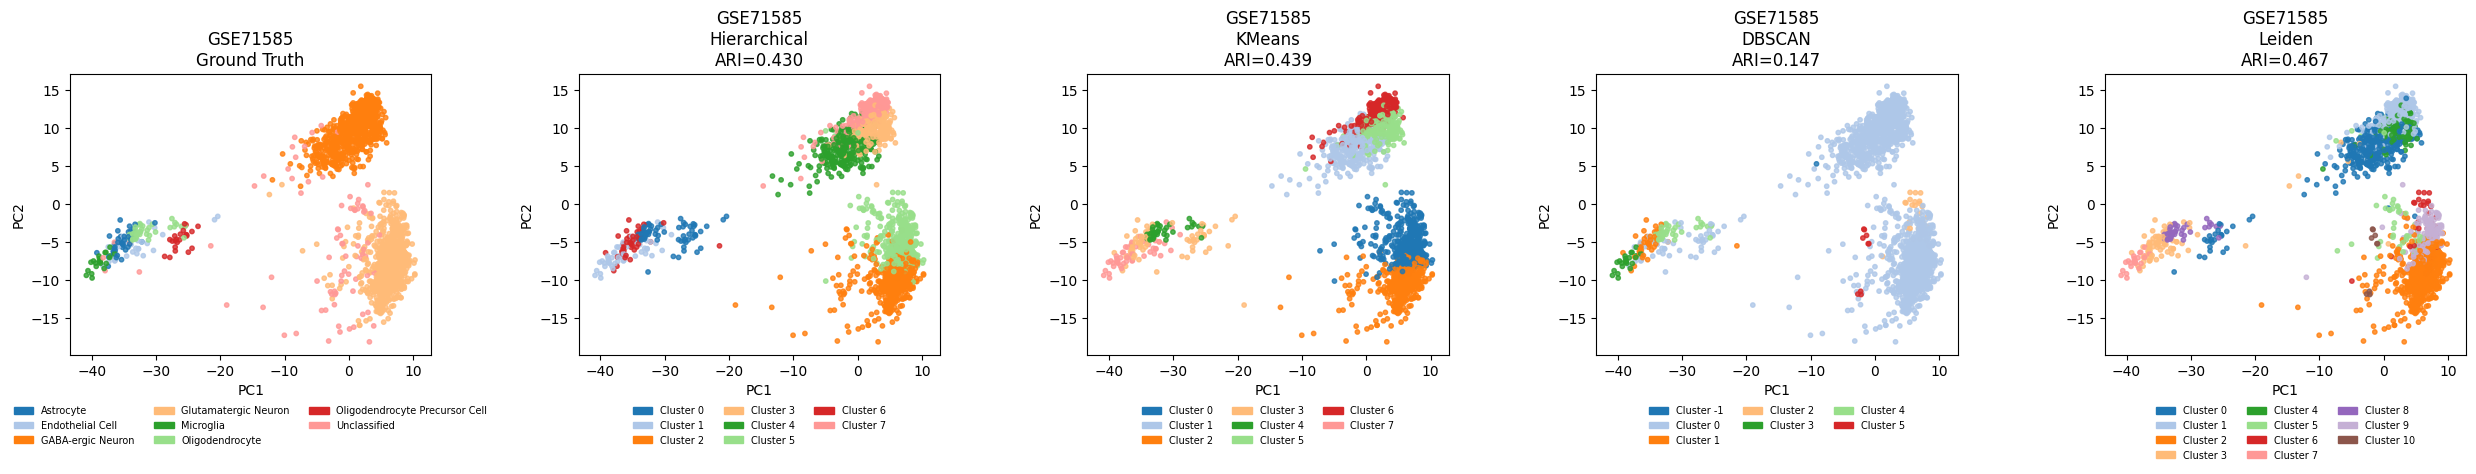

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import umap
import matplotlib.patches as mpatches


def make_palette(n):
    return sns.color_palette("tab20", n) if n <= 20 else sns.color_palette("husl", n)

def legend_for_clusters(cluster_ids, palette):
    return [mpatches.Patch(color=palette[i % len(palette)], label=f"Cluster {cid}")
            for i, cid in enumerate(cluster_ids)]

def legend_for_classes(class_names, palette):
    return [mpatches.Patch(color=palette[i % len(palette)], label=name)
            for i, name in enumerate(class_names)]


def load_gse71585(expr_path, labels_path, label_column="broad_type"):
    expr = pd.read_csv(expr_path, compression='gzip', index_col=0)
    labels_df = pd.read_csv(labels_path, compression='gzip', index_col=0)
    print("Available label columns:", labels_df.columns.tolist())
    labels = labels_df.loc[expr.columns, label_column]
    return expr, labels, "GSE71585"


def run_pipeline(expr, labels, dataset_name, ablation=False):
   
    X = expr.T.astype(np.float32)
    X = X.loc[X.sum(axis=1) > 0]
    labels_aligned = labels.loc[X.index]

    # Normalize & log-transform
    X = X.div(X.sum(axis=1), axis=0) * 1e4
    X = X.fillna(0)
    X_log = np.log1p(X)
    X_log.columns = X_log.columns.astype(str)

    # PCA
    pca_dims = 20 if not ablation else 10  
    X_pca = PCA(n_components=pca_dims, random_state=0).fit_transform(X_log)
    X2 = PCA(n_components=2, random_state=0).fit_transform(X_log)

    # UMAP embedding
    reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(X_log.values)

 
    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(labels_aligned)
    class_names = list(le.classes_)
    class_palette = make_palette(len(class_names))

   
    print("\n=== Fixed Hyperparameters ===")
    print("Hierarchical: linkage='ward', n_clusters = #true labels")
    print("KMeans: n_clusters = #true labels, n_init=10, random_state=0")
    print("DBSCAN: eps=0.5, min_samples=5")
    print("Leiden: n_neighbors=15, resolution=1.0, random_state=0\n")

    results = {}
    metrics_records = []   
    n_clusters = len(np.unique(labels_aligned))

    
    # Hyperparameter sweeps

    # Hierarchical sweep
    for linkage in ["ward", "average"]:
        key = f"Hierarchical_{linkage}"
        results[key] = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit_predict(X_pca)

    # KMeans sweep
    for k in [n_clusters-2, n_clusters, n_clusters+2]:
        key = f"KMeans_k{k}"
        results[key] = KMeans(n_clusters=k, n_init=10, random_state=0).fit_predict(X_pca)

    # DBSCAN sweep
    for eps in [0.3, 0.5, 0.7]:
        key = f"DBSCAN_eps{eps}"
        results[key] = DBSCAN(eps=eps, min_samples=5).fit_predict(X_umap)

    # Leiden sweep
    adata = sc.AnnData(X_log)
    adata.var_names_make_unique()
    sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
    for res in [0.5, 1.0, 1.5]:
        sc.tl.leiden(adata, resolution=res, key_added=f"leiden_{res}",
                     flavor="igraph", n_iterations=2, directed=False)
        results[f"Leiden_res{res}"] = adata.obs[f"leiden_{res}"].astype(int).values

  
    # Evaluation per method
   
    for method, pred in results.items():
        ari = adjusted_rand_score(true_labels_encoded, pred)
        sil = silhouette_score(X_pca, pred) if len(np.unique(pred)) > 1 else np.nan
        metrics_records.append({
            "Method": method,
            "ARI": round(ari, 3),
            "Silhouette": round(sil, 3),
            "n_clusters_pred": len(np.unique(pred))
        })
        print(f"{dataset_name} - {method} | ARI: {ari:.3f}, Silhouette: {sil:.3f}")

        
        true_class_ids = np.unique(true_labels_encoded)
        pred_class_ids = np.unique(pred)
        cm_full = np.zeros((len(true_class_ids), len(pred_class_ids)), dtype=int)
        for i, t in enumerate(true_class_ids):
            for j, p in enumerate(pred_class_ids):
                cm_full[i, j] = np.sum((true_labels_encoded == t) & (pred == p))

        row_labels = [class_names[i] for i in true_class_ids]
        col_labels = [f"Cluster {c}" for c in pred_class_ids]
        cm_df = pd.DataFrame(cm_full, index=row_labels, columns=col_labels)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{dataset_name} - {method} Confusion Matrix")
        plt.ylabel("True broad_type")
        plt.xlabel("Predicted cluster")
        plt.tight_layout()
        plt.show()

        # Scatter plot (2D PCA)
        cluster_ids = list(pred_class_ids)
        cluster_palette = make_palette(len(cluster_ids))
        color_map = {cid: cluster_palette[i % len(cluster_palette)] for i, cid in enumerate(cluster_ids)}
        colors = [color_map[cid] for cid in pred]

        plt.figure(figsize=(6, 6))
        plt.scatter(X2[:, 0], X2[:, 1], c=colors, s=10, alpha=0.8)
        plt.title(f"{dataset_name} - {method}, ARI={ari:.3f}")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        handles = legend_for_clusters(cluster_ids, cluster_palette)
        plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                   ncol=3, fontsize=8, frameon=False)
        plt.tight_layout()
        plt.show()

    metrics_df = pd.DataFrame(metrics_records)
    print("\n=== Summary Table ===")
    print(metrics_df.to_string(index=False))

    all_results = {"Ground Truth": true_labels_encoded}
    all_results.update({
        "Hierarchical": results["Hierarchical_ward"],
        "KMeans": results[f"KMeans_k{n_clusters}"],
        "DBSCAN": results["DBSCAN_eps0.5"],
        "Leiden": results["Leiden_res1.0"]
    })

    fig, axes = plt.subplots(1, len(all_results), figsize=(5*len(all_results), 5))
    if len(all_results) == 1:
        axes = [axes]

    for ax, (method, pred) in zip(axes, all_results.items()):
        if method == "Ground Truth":
            gt_colors = [class_palette[cid] for cid in true_labels_encoded]
            ax.scatter(X2[:, 0], X2[:, 1], c=gt_colors, s=10, alpha=0.8)
            ax.set_title(f"{dataset_name}\n{method}")
            gt_handles = legend_for_classes(class_names, class_palette)
            ax.legend(handles=gt_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                      ncol=3, fontsize=7, frameon=False)
        else:
            cluster_ids = list(np.unique(pred))
            cluster_palette = make_palette(len(cluster_ids))
            color_map = {cid: cluster_palette[i % len(cluster_palette)] for i, cid in enumerate(cluster_ids)}
            colors = [color_map[cid] for cid in pred]
            ari = adjusted_rand_score(true_labels_encoded, pred)
            ax.scatter(X2[:, 0], X2[:, 1], c=colors, s=10, alpha=0.8)
            ax.set_title(f"{dataset_name}\n{method}\nARI={ari:.3f}")
            handles = legend_for_clusters(cluster_ids, cluster_palette)
            ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15),
                      ncol=3, fontsize=7, frameon=False)

        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

    plt.tight_layout()
    plt.show()



expr, labels, name = load_gse71585(
    r"C:\Users\ibrah\OneDrive\Pictures\Bracu courses\CSE443\GSE71585_RefSeq_counts.csv.gz",
    r"C:\Users\ibrah\OneDrive\Pictures\Bracu courses\CSE443\GSE71585_Clustering_Results.csv.gz",
    label_column="broad_type"
)

# Main run (fixed hyperparams + sweeps)
run_pipeline(expr, labels, name, ablation=False)

# Optional: ablation run (e.g., fewer PCs)
# run_pipeline(expr, labels, name, ablation=True)


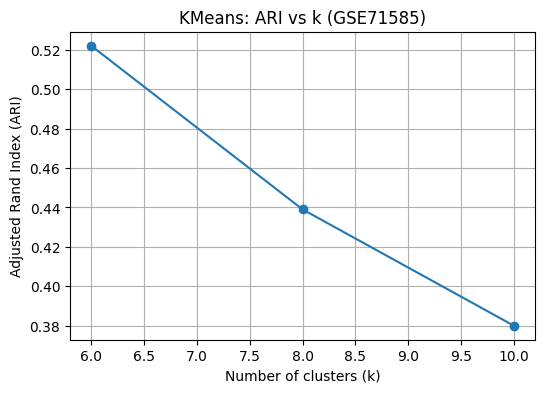

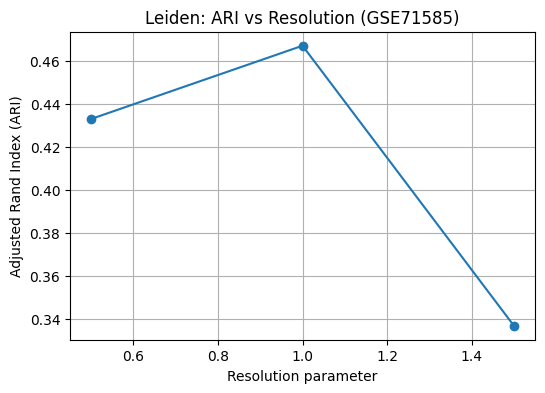

In [4]:
import matplotlib.pyplot as plt

# ---------------------------
# 1. KMeans: ARI vs k
# ---------------------------
k_values = [6, 8, 10]
ari_values = [0.522, 0.439, 0.380]

plt.figure(figsize=(6,4))
plt.plot(k_values, ari_values, marker='o', linestyle='-')
plt.title("KMeans: ARI vs k (GSE71585)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.grid(True)
plt.savefig("kmeans_ari_vs_k.pdf", bbox_inches="tight")
plt.show()

# ---------------------------
# 2. Leiden: ARI vs resolution
# ---------------------------
resolutions = [0.5, 1.0, 1.5]
ari_values = [0.433, 0.467, 0.337]

plt.figure(figsize=(6,4))
plt.plot(resolutions, ari_values, marker='o', linestyle='-')
plt.title("Leiden: ARI vs Resolution (GSE71585)")
plt.xlabel("Resolution parameter")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.grid(True)
plt.savefig("leiden_ari_vs_resolution.pdf", bbox_inches="tight")
plt.show()
